In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas as pd
import os, pdb, re
import string
import keras.preprocessing.text as text
from keras.preprocessing import sequence
from keras import utils
np.set_printoptions(linewidth=300)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from nltk.corpus import stopwords
pd.set_option("display.max_colwidth",200)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
MAX_WORD_COUNT = 60
N_OUT = 5
BATCH_SIZE = 5
HIDDEN_SIZE = 32
NUM_LAYERS = 2
INIT_SCALE = 0.05

In [3]:
fx = lambda x: pd.read_csv(x,delimiter="\t",header=0)
train_df,test_df = map(fx, ["train.tsv","test.tsv"])
feat_names = train_df.columns.values
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Get full sentences from data set

In [4]:
def group_max(group):
    idx = np.where(group["Phrase"].apply(len)==group["Phrase"].apply(len).max())[0][0]
    return group["Phrase"].iloc[idx]
df = train_df.groupby("SentenceId").apply(group_max).values
#remove_stop = lambda sentence: [word for word in sentence if word not in stopwords.words('english')]

In [10]:
df = df[:500]
pd.DataFrame(df)

,0
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story ."
1,"This quiet , introspective and entertaining independent is worth seeking ."
2,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one ."
3,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera ."
4,Aggressive self-glorification and a manipulative whitewash .
5,A comedy-drama of nearly epic proportions rooted in a sincere performance by the title character undergoing midlife crisis .
6,"Narratively , Trouble Every Day is a plodding mess ."
7,"The Importance of Being Earnest , so thick with wit it plays like a reading from Bartlett 's Familiar Quotations"
8,But it does n't leave you with much .
9,You could hate it for the same reason .


In [11]:
n_sentences = df.shape[0]
Tokenizer = text.Tokenizer()
Tokenizer.fit_on_texts(df)
inverse_tokenizer = lambda num: list(Tokenizer.word_index.keys())[list(Tokenizer.word_index.values()).index(num)] #inverse
inverse_tokenizer_sentence = lambda sentence: list(map(inverse_tokenizer,sentence))
vocab_size = len(Tokenizer.word_index) + 1
print("There are {0} unique words in data set.".format(vocab_size))

There are 2905 unique words in data set.


In [12]:
words = Tokenizer.word_index.keys()
encoded_text = Tokenizer.texts_to_sequences(df)
obs = 1
print(df[obs])
print(encoded_text[obs])
print(inverse_tokenizer_sentence(encoded_text[obs]))

This quiet , introspective and entertaining independent is worth seeking .
[19, 305, 854, 4, 227, 855, 6, 186, 856]
['this', 'quiet', 'introspective', 'and', 'entertaining', 'independent', 'is', 'worth', 'seeking']


In [13]:
def data_gen():
    i = k = 0
    batch = np.zeros((BATCH_SIZE,2)).astype(np.int32)
    while True:
        rng.shuffle(df) # shuffle after epoch
        sentence = encoded_text[i]
        sentence_len = len(sentence)
        if sentence_len < 2:
            i+=1
            continue
        for j in range(sentence_len):
            context = sentence[j]

            if j == 0:
                target = sentence[j+1]
            elif j == sentence_len - 1:
                target = sentence[j-1]
            elif rng.uniform() < 0.5:
                target = sentence[j-1]
            else:
                target = sentence[j+1]

            batch[k,0] = context
            batch[k,1] = target
            if k == BATCH_SIZE - 1:
                k = 0
                yield batch
                batch = np.zeros((BATCH_SIZE,2)).astype(np.int32)
            else:
                k+=1
        i+=1
        if i == len(encoded_text):
            #print("Finished Epoch")
            i = 0
                

## Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size”

<tf.Tensor 'add_2:0' shape=(2905,) dtype=float32>

In [55]:
NUM_STEPS = MAX_WORD_COUNT
train_inputs = tf.placeholder(tf.int32,shape=[None])
train_labels = tf.placeholder(tf.int32,shape=[None,1])
embeddings = tf.Variable(tf.random_uniform([vocab_size, HIDDEN_SIZE])) # NUmber of words by hidden
embed = tf.nn.embedding_lookup(embeddings, train_inputs) #lookup action on the embedding tensor, where each word in the input data set is matched with a row in the embedding tensor, with the matched embedding vector being returned within inputs.

#loss
num_sampled = 1
nce_weights = tf.Variable(
  tf.truncated_normal([vocab_size, HIDDEN_SIZE],
                      stddev=1.0 / np.sqrt(HIDDEN_SIZE)))
nce_biases = tf.Variable(tf.zeros([vocab_size]))
logits = tf.reduce_sum(tf.multiply(embeddings,nce_weights),1) + nce_biases
loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocab_size))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.3).minimize(loss)
saver = tf.train.Saver()

In [56]:
n = 30000
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    generate_batch = data_gen()
    cur_losses = []
    for i in range(n):
        data = next(generate_batch)
        feed_dict = {train_inputs: data[:,0],train_labels:data[:,[1]]}
        _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        cur_losses.append(cur_loss)
        if i % 1000 == 0:
            print("{0} of {1} with loss of {2:.3f}".format(i,n,np.mean(cur_losses)))
            cur_losses = []
    save_path = saver.save(sess, "/tmp/model.ckpt")
    idx = np.arange(1,vocab_size)
    learnt_embed = embed.eval(feed_dict={train_inputs:idx})


0 of 30000 with loss of 4.886
1000 of 30000 with loss of 4.803
2000 of 30000 with loss of 3.750
3000 of 30000 with loss of 3.497
4000 of 30000 with loss of 3.161
5000 of 30000 with loss of 3.260
6000 of 30000 with loss of 2.761
7000 of 30000 with loss of 2.839
8000 of 30000 with loss of 2.715
9000 of 30000 with loss of 2.614
10000 of 30000 with loss of 2.591
11000 of 30000 with loss of 2.384
12000 of 30000 with loss of 2.382
13000 of 30000 with loss of 2.120
14000 of 30000 with loss of 2.306
15000 of 30000 with loss of 2.183
16000 of 30000 with loss of 2.124
17000 of 30000 with loss of 2.108
18000 of 30000 with loss of 2.099
19000 of 30000 with loss of 1.909
20000 of 30000 with loss of 1.797
21000 of 30000 with loss of 1.786
22000 of 30000 with loss of 1.722
23000 of 30000 with loss of 1.782
24000 of 30000 with loss of 1.629
25000 of 30000 with loss of 1.667
26000 of 30000 with loss of 1.512
27000 of 30000 with loss of 1.666
28000 of 30000 with loss of 1.628
29000 of 30000 with loss of

In [21]:
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(learnt_embed)
labels = inverse_tokenizer_sentence(idx)

In [96]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    word = 1
    print(inverse_tokenizer(word))
    logits_ = logits.eval(feed_dict={train_inputs:np.array([word])})

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
the


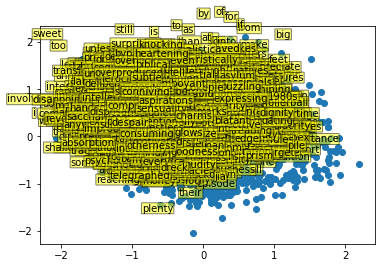

In [18]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))
for label, x, y in zip(labels, X_embedded[:, 0], X_embedded[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.05', fc='yellow', alpha=0.5))
        #arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))